In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
import torchvision.transforms as tt
import torch
from torch import device
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import spectral_norm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
batch_size = 32
latent_size= 50
image_size = 24

In [5]:
# !mkdir cryptopunks
# !unzip -qq sample_data/sorted_dataset.zip -d /content/cryptopunks/

# Новый раздел

In [6]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train = ImageFolder('/content/drive/MyDrive/cryptopunks/sorted_dataset/imgs', transform=tt.Compose([tt.Resize(image_size),
                                                  tt.ToTensor(),
                                                  tt.Normalize(*stats)]))
 
train_loader = DataLoader(train, batch_size, shuffle=True, pin_memory=True, drop_last=True) 

In [7]:
# for images, labels in train_loader:
#     target = nn.functional.one_hot(labels.unsqueeze(1).unsqueeze(1), 5).permute(0,3,1,2).to(device)
#     print(target.shape , images.shape)
# label size = [32,5,1,1]

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(latent_size+5, 512, kernel_size=2, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )

        self.upsample2 = nn.Sequential(
            #nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=0, bias=False),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
                
        self.upsample3 = nn.Sequential(
            #nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0, bias=False),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True)            
        )

        self.upsample4 = nn.Sequential(
            #nn.ConvTranspose2d(128, 24, kernel_size=3, stride=1, padding=0, bias=False),
            nn.ConvTranspose2d(128, 24, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(True)    
        )

        # self.upsample6 = nn.Sequential(
        #     nn.ConvTranspose2d(24, 24, kernel_size=3, stride=2, padding=0, bias=False),
        #     nn.BatchNorm2d(24),
        #     nn.ReLU(True)    
        # )

        self.upsample5 = nn.Sequential(
            #nn.ConvTranspose2d(24, 3, kernel_size=4, stride=1, padding=0, bias=False),
            nn.ConvTranspose2d(24, 3, kernel_size=2, stride=2, padding=4, bias=False),
            nn.Tanh(),
        )

    def forward(self, x, class_vec):
        x = torch.cat([x,class_vec], 1)
        x = self.upsample1(x)
        x = self.upsample2(x)
        x = self.upsample3(x)
        x = self.upsample4(x)
        #x = self.upsample6(x)
        x = self.upsample5(x)
        return x

generator = Generator()
#summary(generator.to(device), (28, 1, 1), batch_size=batch_size)

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(5,24*24),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, torch.Size([1,24,24]))
            )
        self.conv1 = nn.Sequential(
            #nn.Conv2d(4, 24, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Conv2d(4, 24, kernel_size=2, stride=2, padding=4, bias=False),
            nn.BatchNorm2d(24),
            nn.LeakyReLU(0.2, inplace=True)
        #    nn.Flatten()   
        )        
        # self.conv6 = nn.Sequential(
        #     nn.Conv2d(24, 24, kernel_size=3, stride=2, padding=0, bias=False),
        #     nn.BatchNorm2d(24),
        #     nn.LeakyReLU(0.2, inplace=True)
        # )

        self.conv2 = nn.Sequential(
           # nn.Conv2d(24, 128, kernel_size=3, stride=1, padding=0, bias=False),
            nn.Conv2d(24, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv3 = nn.Sequential(
            #nn.Conv2d(128, 256, kernel_size=2, stride=2, padding=0, bias=False),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True) 
        )

        self.conv4 = nn.Sequential(
           # nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=0, bias=False),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=2, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x, class_vec):
        c = self.fc1(class_vec.view(class_vec.size(0),-1)),
        x = torch.cat([x, c[0]],1)
        x = self.conv1(x)
       # x = self.conv6(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        return x
discriminator = Discriminator()
#summary(discriminator.to(device), (1,28,28), batch_size= batch_size)

In [10]:
def denorm(img_tensors):
    return img_tensors * 0.5 + 0.5

In [11]:
sample_dir = '/content/drive/MyDrive/cryptopunks/generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, target, show=True):
    fake_images = generator(latent_tensors, target).to(device)
    fake_fname = 'image-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [12]:
def train_discriminator(real_images, opt_d, target):
    # обнуляем градиенты у дискриминатора, сейчас мы будем его учить
    opt_d.zero_grad()

    # получаем предсказания дискриминатора на настоящих картинках
    real_preds = discriminator(real_images, target).to(device)

    # делаем вектор меток для настоящих картинок - он состоит из единиц
    # real_targets = torch.ones(real_images.size(0), 1).to(device) 
    real_targets = torch.ones(real_images.size(0), 1).to(device) 

    # считаем лосс между предсказаниями и настоящими метками
    # real_loss = torch.log(real_preds)
    real_loss = F.binary_cross_entropy(real_preds, real_targets) 

    # записываем усредненные предсказания дискриминатора
    real_score = torch.mean(real_preds).item()
    
    # создаем случайный шум: из него генератор нам что-нибудь нагенерирует
    latent = torch.randn(real_images.size(0), latent_size, 1, 1).to(device) 

    # получаем фейковые изображения
    fake_images = generator(latent, target).to(device)  

    # делаем вектор меток класса для фейковых изображений
    fake_targets = torch.zeros(fake_images.size(0), 1).to(device) 

    # получаем предсказания дискриминатора для фейковых изображений
    fake_preds = discriminator(fake_images, target).to(device)  

    # считаем лосс на фейковых изображениях
    # fake_loss = torch.log(1 - fake_preds)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)  

    # записываем усредненные предсказания дискриминатора на фейках
    fake_score = torch.mean(fake_preds).item()

    # итоговый лосс - сумма двух лоссов
    loss = torch.mean(real_loss + fake_loss*5)

    # делаем обратный проход
    loss.backward()

    # обновляем веса дискриминатора
    opt_d.step()

    return loss.item(), real_score, fake_score, real_loss, fake_loss

In [13]:
def train_generator(opt_g, target):
    # обнуляем веса генератора
    opt_g.zero_grad()

    # генерируем случайный вектор для генератора
    latent = torch.randn(target.size(0), latent_size, 1,1).to(device) 

    # получаем фейковые изображения
    fake_images = generator(latent, target).to(device) 
    
    # получаем предсказания дискриминатора для фейковых изображений
    preds = discriminator(fake_images, target).to(device) 

    # делаем вектор меток класса - теперь они единицы для фейковых картинок
    targets = torch.ones(batch_size, 1).to(device)

    # считаем лосс
    # loss = torch.mean(torch.log(1 - preds))
    loss = F.binary_cross_entropy(preds, targets) 

    # делаем обратный проход
    loss.backward()

    # обновляем веса генератора
    opt_g.step()
    
    return loss.item(), latent

In [14]:
def fit(epochs=50, lr=0.0002, start_idx=1):
    torch.cuda.empty_cache()
    
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
  
    opt_d = torch.optim.Adam(discriminator.to(device).parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.to(device).parameters(), lr=lr, betas=(0.5, 0.999))
    fake_score = 0
    loss = 10
    for epoch in range(epochs):
        for real_images, labels in tqdm(train_loader):
            target = nn.functional.one_hot(labels.unsqueeze(1).unsqueeze(1), 5).permute(0,3,1,2).float()
            target=(target*0.96).to(device)
            real_images = real_images.to(device)

            loss_d, real_score, fake_score, real_loss, fake_loss = train_discriminator(real_images, opt_d, target)
            loss_g, latent = train_generator(opt_g, target)
            torch.save(generator.state_dict(), '/content/drive/MyDrive/cryptopunks/result24_1/punk_generator_ws24_'+str(epoch+1)+'.pt')
            torch.save(discriminator.state_dict(), '/content/drive/MyDrive/cryptopunks/result24_1/punk_discriminator_ws24_'+str(epoch+1)+'.pt')

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print(f"[{epoch+1}/{epochs}], real_loss: {real_loss:.4f}, fake_loss: {fake_loss:.4f}, loss_g: {loss_g:.4f}, loss_d: {loss_d:.4f}, real_score: {real_score:.4f}, fake_score: {fake_score:.4f}")
        save_samples(epoch+start_idx, latent, target, show=False)
    
    return losses_g, losses_d, latent, fake_scores

In [15]:
generator.load_state_dict(torch.load('/content/drive/MyDrive/cryptopunks/result24_1/punk_generator_ws24_58.pt', map_location=torch.device('cuda')))

<All keys matched successfully>

In [ ]:
loss_g, loss_d, latent, fake_scores = fit(epochs=150)

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 4, 3, 3, 2, 3, 1,
        3, 2, 3, 3, 3, 2, 2, 3])
tensor([3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 2, 3, 3, 2, 2, 2, 3, 3,
        3, 3, 3, 3, 2, 3, 3, 2])
tensor([3, 3, 2, 3, 3, 3, 3, 4, 3, 3, 2, 2, 2, 2, 3, 2, 3, 3, 2, 3, 2, 2, 3, 3,
        4, 3, 2, 3, 3, 3, 3, 2])
tensor([2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3,
        3, 3, 3, 2, 3, 2, 3, 3])
tensor([2, 2, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 2, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 3, 2,
        2, 3, 2, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 2])
tensor([3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 4,
        3, 3, 3, 2, 3, 3, 3, 3])
tensor([2, 3, 3, 3, 2, 3, 3, 4, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 2, 3, 2, 3, 3,
        3, 2, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([4, 3, 3, 2, 2, 3, 2, 4, 2, 3, 2, 2, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2,
        3, 3, 3, 2, 2, 2, 2, 3])
tensor([3, 4, 3, 2, 3, 3, 2, 3, 2, 2, 4, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3,
        3, 2, 3, 3, 2, 3, 2, 3])
tensor([3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 4, 3, 3, 3, 3, 3, 3, 3, 2, 3,
        2, 3, 3, 2, 3, 2, 3, 3])
tensor([2, 3, 3, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 4, 2, 3, 3, 2, 3, 2, 3, 3,
        3, 3, 3, 2, 2, 3, 2, 3])
tensor([3, 3, 2, 3, 3, 2, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3,
        3, 3, 3, 2, 2, 2, 4, 3])
tensor([3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 2, 3])
tensor([3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 2, 3, 3, 2,
        3, 3, 3, 3, 3, 2, 2, 3])
tensor([2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 2, 3, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3, 3,
        3, 2, 3, 3, 2, 3, 3, 3])
tensor([3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3,
        3, 3, 2,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 3, 3, 2, 2, 3, 3, 3])
tensor([2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 2,
        3, 2, 3, 3, 3, 3, 3, 2])
tensor([2, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 2])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 4, 3, 2, 2, 3, 2, 2, 3, 3, 3, 3, 2, 2,
        2, 3, 3, 3, 3, 3, 2, 3])
tensor([3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3,
        3, 3, 3, 4, 3, 3, 3, 2])
tensor([2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 2])
tensor([3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 3, 3, 2, 3, 3, 2])
tensor([2, 3, 3, 3, 2, 4, 2, 3, 3, 3, 3, 2, 3, 3, 4, 3, 3, 3, 3, 3, 3, 2, 3, 3,
        3, 2, 2,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 2, 2, 3, 2, 0, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2,
        3, 3, 3, 3, 2, 3, 3, 3])
tensor([3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 4, 3,
        3, 3, 3, 2, 3, 2, 2, 3])
tensor([3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 2, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3,
        2, 3, 3, 3, 3, 2, 3, 3])
tensor([2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2,
        3, 3, 2, 3, 3, 2, 2, 3])
tensor([3, 2, 2, 3, 2, 3, 2, 3, 2, 2, 2, 3, 3, 3, 2, 3, 2, 3, 2, 2, 3, 2, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 3, 3, 3, 2, 3, 2, 2,
        3, 3, 2, 3, 3, 2, 3, 2])
tensor([3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3,
        3, 3, 2, 2, 3, 3, 3, 2])
tensor([2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 2, 2, 3, 2, 2, 3, 2,
        3, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 3, 3, 4, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
        3, 3, 1, 3, 2, 2, 3, 2])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3,
        2, 2, 3, 2, 3, 2, 3, 2])
tensor([3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3,
        3, 3, 2, 3, 3, 2, 3, 3])
tensor([3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 2, 2, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        3, 3, 2, 2, 3, 3, 3, 2])
tensor([3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 2, 3])
tensor([2, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 2, 2, 3, 3, 2, 3, 2, 2, 3, 2, 3, 3, 3,
        3, 4, 3, 3, 2, 3, 3, 3])
tensor([3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 2, 3,
        3, 2, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
        3, 2, 3, 3, 3, 3, 2, 3])
tensor([2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        2, 3, 3, 3, 3, 3, 2, 2])
tensor([3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3,
        3, 3, 3, 3, 2, 3, 3, 3])
tensor([2, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2,
        3, 2, 3, 3, 3, 2, 3, 3])
tensor([3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 2, 3,
        3, 2, 3, 2, 3, 3, 3, 3])
tensor([3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 4, 2, 3, 3, 3, 2, 3, 3, 3, 2,
        3, 4, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 2, 3, 3, 4, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 3,
        2, 3, 3, 3, 3, 3, 3, 2])
tensor([3, 2, 3, 2, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 2, 3, 3])
tensor([3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 2, 3, 3, 2, 3, 2, 2,
        2, 2, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2,
        2, 3, 3, 3, 2, 3, 3, 3])
tensor([2, 3, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 0, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 2, 2, 3])
tensor([2, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
        3, 3, 3, 3, 3, 2, 3, 3])
tensor([2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 3, 3,
        3, 2, 3, 2, 3, 3, 2, 3])
tensor([3, 2, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2,
        3, 3, 3, 2, 3, 3, 2, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3,
        3, 2, 3, 3, 3, 3, 3, 2])
tensor([3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 2, 4, 3, 3, 3, 2, 2])
tensor([3, 3, 2, 2, 3, 3, 3, 3, 4, 3, 3, 3, 3, 2, 2, 3, 2, 2, 3, 3, 3, 3, 2, 3,
        2, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 2, 3, 2, 3, 3, 3, 2, 3, 2, 3,
        3, 3, 3, 3, 2, 3, 3, 2])
tensor([2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 2, 2, 3])
tensor([3, 2, 3, 3, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2,
        2, 3, 2, 2, 3, 3, 2, 3])
tensor([2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 2,
        2, 3, 3, 3, 3, 3, 3, 2])
tensor([3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 4, 3, 3, 2, 3, 3, 2, 3, 2, 3,
        3, 3, 3, 2, 3, 3, 2, 3])
tensor([2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3,
        3, 2, 3, 2, 2, 3, 3, 3])
tensor([3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2,
        3, 3, 3, 2, 3, 3, 2, 4])
tensor([3, 3, 2, 3, 2, 2, 3, 4, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2,
        2, 3, 3, 3, 3, 3, 2, 3])
tensor([3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3,
        3, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([2, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 3, 4, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2,
        4, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
        3, 2, 3, 2, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2,
        3, 3, 3, 3, 3, 2, 3, 3])
tensor([3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2,
        3, 3, 2, 3, 2, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3,
        3, 3, 3, 2, 3, 3, 2, 3])
tensor([3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3,
        3, 3, 2, 3, 2, 3, 2, 2])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 3])
tensor([3, 2, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 2, 3, 3, 3, 2, 3, 3])
tensor([3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3,
        3, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 2, 3, 2, 3,
        2, 3, 2, 3, 3, 3, 2, 3])
tensor([3, 2, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3,
        3, 2, 2, 3, 3, 3, 3, 2])
tensor([3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 2, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3,
        2, 3, 3, 2, 3, 3, 3, 2])
tensor([3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
        3, 2, 2, 3, 3, 3, 3, 3])
tensor([3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 2,
        3, 2, 3, 2, 3, 2, 2, 4])
tensor([3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3, 2, 3, 3, 2, 3, 3, 2,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([2, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2,
        2, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3,
        2, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 2, 2, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 4, 3,
        3, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 2, 2, 3, 3, 3, 3])
tensor([3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 2])
tensor([3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 3,
        3, 2, 3, 3, 2, 3, 3, 3])
tensor([2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 2, 2, 2,
        3, 2, 3, 2, 3, 3, 3, 2])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 2, 3, 3, 3,
        3, 3, 2, 3, 2, 2, 2, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 2, 3])
tensor([3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3,
        3, 3, 2, 3, 2, 3, 3, 3])
tensor([2, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 1, 3, 1, 3, 2, 3,
        3, 2, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([2, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 3,
        3, 3, 3, 3, 4, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 2, 3, 2, 3, 2, 3, 3])
tensor([3, 3, 2, 3, 2, 3, 2, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3,
        2, 3, 3, 2, 2, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3,
        2, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 2, 3, 3, 2, 3, 2, 2, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 2, 2, 3, 2, 2, 3,
        2, 3, 2, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 2, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 2, 3, 2, 2, 3])
tensor([3, 3, 3, 3, 2, 4, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3,
        3, 3, 3, 3, 3, 2, 3, 3])
tensor([3, 2, 3, 3, 2, 2, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 2,
        2, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3,
        3, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 2, 2, 3, 2, 3, 2, 3,
        2, 2, 3, 3, 3, 3, 2, 3])
tensor([3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 2, 2,
        3, 3, 3, 3, 3, 3, 2, 3])
tensor([3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3,
        2, 3, 3, 4, 3, 2, 3, 2])
tensor([3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 2, 3, 3, 2, 2, 3,
        3, 3, 2, 2, 3, 3, 3, 3])
tensor([3, 2, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([2, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 4, 3, 3, 3, 3, 2, 3,
        3, 3, 2, 3, 2, 3, 2, 2])
tensor([3, 3, 3, 2, 3, 2, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3,
        2, 2, 3, 2, 3, 3, 2, 2])
tensor([3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 2, 4, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2,
        3, 3, 2,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        2, 2, 3, 2, 3, 3, 3, 3])
tensor([3, 3, 3, 4, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 4, 3, 3, 4, 3, 3, 3, 2, 3, 3,
        3, 3, 3, 3, 3, 2, 3, 3])
tensor([3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 2, 3])
tensor([2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 2,
        3, 3, 2, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 2, 3, 3, 3, 3, 2, 2])
tensor([3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3,
        2, 2, 3, 2, 3, 2, 3, 3])
tensor([3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 2, 3, 1, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3,
        3, 3, 3, 2, 3, 3, 3, 3])
tensor([2, 2, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3,
        2, 2, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2,
        2, 2, 2, 3, 2, 3, 3, 3])
tensor([3, 3, 3, 2, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2,
        3, 3, 2, 3, 3, 3, 3, 2])
tensor([3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 1, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 4, 3, 3,
        3, 3, 4, 3, 2, 3, 3, 3])
tensor([2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 2,
        2, 3, 3, 2, 3, 3, 2, 2])
tensor([3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3,
        2, 3, 3, 3, 3, 2, 2, 2])
tensor([3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
        3, 4, 2, 3, 3, 3, 2, 3])
tensor([2, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        2, 2, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 4, 3, 2, 3, 3, 3, 3,
        2, 3, 3, 2, 3, 3, 2, 3])
tensor([2, 3, 2, 3, 3, 2, 3, 0, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
        2, 2, 1, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
        2, 3, 2, 3, 3, 3, 3, 2])
tensor([2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 2, 4, 1, 3, 2, 3,
        3, 3, 3, 3, 3, 2, 2, 3])
tensor([3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2,
        3, 2, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 2, 3,
        3, 3, 2, 3, 2, 3, 3, 3])
tensor([3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 2, 2, 3, 3, 2, 3, 3, 2,
        3, 2, 3, 3, 3, 2, 3, 2])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 3, 3, 3, 2,
        3, 2, 3, 3, 2, 3, 2, 3])
tensor([3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3,
        3, 2, 2, 3, 3, 2, 3, 3])
tensor([3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3,
        3, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 4, 3, 3, 3, 3, 3,
        3, 3, 3, 2, 2, 3, 3, 3])
tensor([3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3,
        3, 2, 2, 3, 3, 3, 3, 3])
tensor([3, 2, 3, 3, 3, 3, 3, 4, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3,
        3, 3, 2, 3, 3, 2, 3, 3])
tensor([2, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 2, 3, 3, 4, 2, 3, 2, 2, 3, 3, 2, 2, 3,
        3, 3, 2, 3, 3, 2, 2, 3])
tensor([3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3,
        2, 3, 2, 2, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 2])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3,
        3, 2, 3, 3, 2, 2, 2, 1])
tensor([3, 2, 3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2,
        2, 3, 3, 3, 3, 3, 2, 3])
tensor([2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2,
        2, 4, 2,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([2, 2, 3, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 2, 3, 2, 2])
tensor([2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 2])
tensor([2, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 3])
tensor([3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3,
        2, 2, 3, 3, 3, 2, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3,
        2, 3, 3, 3, 3, 4, 3, 3])
tensor([2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
        3, 1, 2, 3, 2, 2, 2, 3])
tensor([2, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2,
        3, 3, 2, 3, 3, 2, 3, 3])
tensor([2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3,
        2, 3, 3, 2, 3, 3, 3, 3])
tensor([2, 2, 2, 3, 2, 4, 2, 2, 1, 3, 3, 3, 4, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3,
        2, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
        3, 3, 3, 2, 2, 2, 3, 3])
tensor([3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3,
        3, 3, 3, 3, 2, 3, 3, 3])
tensor([2, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2,
        2, 2, 2, 3, 3, 2, 3, 3])
tensor([2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2,
        3, 3, 3, 2, 2, 3, 3, 2])
tensor([3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2,
        3, 3, 2, 3, 3, 3, 3, 3])
tensor([3, 3, 0, 3, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2,
        3, 3, 3, 2, 3, 3, 3, 3])
tensor([2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 2, 3, 2, 2, 3, 2,
        3, 2, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
        3, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2,
        3, 3, 3, 2, 3, 2, 3, 2])
tensor([4, 3, 2, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 1,
        3, 2, 2, 2, 3, 2, 3, 3])
tensor([3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 2,
        3, 3, 3, 3, 3, 3, 2, 3])
tensor([3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3,
        3, 3, 3, 2, 3, 3, 3, 3])
tensor([3, 3, 2, 3, 2, 2, 2, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3,
        3, 3, 1, 2, 3, 3, 2, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
        2, 3, 2, 3, 3, 3, 2, 2])
tensor([2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 4, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
        3, 2, 2, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3,
        2, 3, 3, 3, 3, 3, 3, 2])
tensor([3, 3, 3, 3, 2, 2, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 2, 3, 3, 3, 3,
        3, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
        3, 3, 2, 3, 3, 3, 2, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 4, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 1, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 2, 2, 3, 2, 3, 2, 2,
        3, 2, 3, 3, 3, 2, 4, 3])
tensor([3, 2, 2, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
        2, 3, 2, 2, 3, 3, 2, 3])
tensor([3, 3, 3, 2, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
        3, 3, 3, 3, 2, 3, 3, 2])
tensor([3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
        2, 3, 3, 2, 2, 3, 3, 3])
tensor([3, 2, 2, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3,
        2, 3, 3, 3, 3, 2, 3, 3])
tensor([3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 2, 2, 3, 2,
        2, 2, 3, 3, 2, 2, 2, 2])
tensor([2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
        3, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 3, 3, 2, 4, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 1, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2,
        3, 2, 3, 3, 3, 2, 3, 2])
tensor([3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 4, 3, 3, 3, 2, 3, 2, 2, 3,
        3, 3, 3, 3, 4, 2, 3, 3])
tensor([3, 3, 3, 3, 2, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
        2, 3, 2, 2, 2, 3, 3, 3])
tensor([3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3,
        3, 3, 2, 3, 3, 2, 3, 3])
tensor([3, 3, 3, 2, 2, 2, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3,
        3, 2, 3, 3, 3, 2, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 4, 2, 3, 3, 3, 3, 3, 3, 2, 2,
        3, 2, 3, 3, 2, 2, 3, 2])
tensor([2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2,
        3, 2, 3, 3, 2, 3, 3, 2])
tensor([3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3,
        3, 3, 2,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2, 3, 2,
        3, 2, 3, 3, 3, 3, 3, 3])
tensor([2, 2, 4, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([2, 3, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3,
        2, 3, 3, 3, 3, 2, 3, 3])
tensor([2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3,
        3, 3, 2, 3, 2, 3, 3, 3])
tensor([2, 2, 3, 2, 4, 3, 3, 3, 3, 4, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 2, 3, 2,
        3, 3, 2, 2, 3, 3, 3, 2])
tensor([2, 1, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 4, 3, 1, 3, 2, 3, 3,
        3, 3, 3, 4, 3, 3, 3, 3])
tensor([2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 2,
        3, 3, 2, 3, 3, 3, 2, 2])
tensor([3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 0, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 2, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2,
        3, 3, 3, 3, 3, 3, 3, 2])
tensor([2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 2])
tensor([3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 4, 2, 3, 2, 3, 3, 3, 2, 3,
        2, 3, 3, 3, 2, 2, 3, 3])
tensor([3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 3, 2, 3, 2, 3, 2, 3, 2, 4, 3, 2, 3, 3, 3,
        2, 3, 3, 3, 3, 3, 3, 2])
tensor([2, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 0, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
        2, 3, 3, 3, 0, 3, 3, 3])
tensor([3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 2, 3, 3, 3,
        3, 3, 2, 2, 3, 2, 3, 3])
tensor([2, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2,
        2, 2, 2, 3, 2, 3, 3, 3])
tensor([3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 2, 2, 3, 3, 2, 3, 2, 3, 2,
        2, 3, 3, 2, 3, 3, 4, 3])
tensor([2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3,
        3, 2, 2,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 2, 2, 2, 3, 3, 3, 2, 3,
        3, 3, 3, 2, 3, 3, 2, 2])
tensor([3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 2,
        2, 3, 3, 2, 3, 3, 3, 3])
tensor([3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 2, 3])
tensor([2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 2,
        3, 2, 2, 3, 3, 3, 3, 3])
tensor([3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 4, 2, 2, 3, 3, 3, 3, 3,
        3, 3, 3, 2, 3, 3, 3, 3])
tensor([2, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 2, 3, 3, 3, 2])
tensor([2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2,
        2, 3, 2, 3, 3, 3, 3, 3])
tensor([3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 2,
        2, 3, 3, 2, 3, 3, 2, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 2, 2,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 2, 3, 3, 2, 3])
tensor([3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
        3, 2, 3, 3, 3, 3, 2, 3])
tensor([3, 3, 3, 3, 3, 4, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2,
        3, 3, 3, 3, 2, 3, 3, 2])
tensor([3, 4, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3,
        2, 3, 3, 2, 3, 2, 3, 2])
tensor([3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3,
        3, 2, 3, 3, 3, 3, 3, 3])
tensor([2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 2, 3, 3,
        3, 2, 3, 3, 3, 3, 2, 3])
tensor([3, 3, 2, 3, 3, 3, 4, 2, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 4, 3,
        2, 3, 3, 3, 3, 3, 2, 3])
tensor([3, 2, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3,
        2, 3, 3, 3, 2, 3, 2, 3])
tensor([3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 2])
tensor([3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 2, 3, 3, 3])
tensor([3, 3, 2, 3, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
        2, 2, 3, 3, 3, 3, 3, 3])
tensor([2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 2, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 2, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 4,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 2, 2,
        3, 2, 4, 3, 2, 3, 2, 3])
tensor([3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3,
        2, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3,
        3, 3, 2, 3, 3, 2, 3, 2])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 2, 2, 3,
        2, 3, 3, 3, 3, 3, 2, 2])
tensor([2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 2, 2, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 2, 3, 2, 3, 2, 3, 3, 3,
        3, 2, 3, 3, 3, 2, 3, 3])
tensor([3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 4,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3,
        2, 3, 3, 3, 3, 3, 2, 3])
tensor([3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
        3, 3, 3, 3, 3, 3, 3, 2])
tensor([3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 2, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 4, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3,
        2, 2, 3, 3, 3, 3, 3, 3])
tensor([2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 1, 3, 3, 3, 2, 3, 3, 3, 3, 2,
        2, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 2, 2, 3, 2, 2, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 2])
tensor([3, 4, 3, 3, 3, 2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 2, 3])
tensor([4, 4, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 2, 3, 3])
tensor([2, 3, 3, 2, 3, 3, 2, 3, 2, 2, 3, 2, 2, 3, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3,
        3, 2, 2, 3, 3, 3, 3, 3])
tensor([2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 4, 3,
        2, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 2, 3, 3, 2, 2, 3, 2, 2, 3, 3,
        4, 3, 2, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 2,
        3, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3,
        3, 3, 3, 2, 2, 3, 3, 3])
tensor([3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 2, 2, 3,
        3, 3, 3, 3, 3, 2, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3,
        3, 3, 3, 3, 2, 3, 3, 2])
tensor([2, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2,
        3, 3, 2, 2, 3, 3, 3, 3])
tensor([3, 4, 3, 2, 2, 3, 4, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3,
        3, 3, 3, 2, 2, 3, 2, 4])
tensor([3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 3, 2, 3, 2, 3, 4, 3, 3,
        3, 3, 3, 3, 2, 3, 3, 3])
tensor([3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3,
        2, 2, 3, 3, 3, 3, 3, 2])
tensor([2, 3, 3, 3, 3, 2, 3, 2, 3, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 2, 3, 3, 2, 3,
        3, 3, 3, 3, 2, 3, 3, 2])
tensor([3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 2,
        2, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3,
        2, 2, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3,
        3, 3, 2, 2, 3, 3, 3, 2])
tensor([2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 4, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        3, 3, 2, 3, 2, 3, 3, 3])
tensor([3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2,
        2, 2, 3, 3, 3, 2, 3, 3])
tensor([3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 2])
tensor([3, 2, 3, 3, 2, 3, 3, 3, 3, 2, 4, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2,
        3, 3, 3, 3, 3, 3, 2, 3])
tensor([3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3,
        3, 3, 3, 2, 3, 2, 3, 3])
tensor([2, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 2, 3,
        2, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3,
        3, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 2,
        3, 2, 3, 3, 3, 2, 3, 3])
tensor([3, 3, 3, 2, 3, 2, 2, 3, 1, 2, 2, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 2, 3, 3,
        2, 2, 3, 3, 3, 3, 3, 3])
tensor([2, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3,
        3, 2, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 4, 3, 3, 3, 2,
        3, 3, 3, 2, 3, 2, 2, 3])
tensor([3, 3, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2,
        3, 2, 3, 2, 2, 3, 3, 3])
tensor([3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 4, 3,
        2, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 2, 2,
        2, 3, 3, 3, 3, 2, 3, 3])
tensor([3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 2, 2, 3])
tensor([3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3,
        3, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2,
        2, 2, 3, 2, 3, 3, 3, 2])
tensor([2, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2,
        2, 2, 2, 2, 2, 3, 3, 2])
tensor([3, 3, 2, 2, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 2, 3, 3, 3, 3,
        3, 3, 3, 2, 2, 3, 2, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3,
        3, 2, 2, 2, 3, 3, 3, 3])
tensor([2, 3, 3, 3, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3,
        2, 1, 3, 2, 3, 2, 3, 3])
tensor([3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 2, 3, 3, 3, 3, 2, 3])
tensor([3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 1,
        3, 3, 3, 2, 3, 3, 3, 3])
tensor([3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
        3, 2, 3, 3, 3, 3, 3, 3])
tensor([3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3,
        2, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 2, 3,
        3, 3, 2, 2, 3, 2, 2, 3])
tensor([3, 3, 2, 3, 2, 2, 3, 2, 3, 3, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3,
        3, 3, 3, 2, 2, 3, 2, 2])
tensor([3, 2, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3,
        2, 3, 2, 3, 3, 2, 3, 2])
tensor([2, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 2, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3,
        2, 3, 2, 3, 2, 3, 2, 2])
tensor([3, 2, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3,
        2, 2, 2, 4, 3, 2, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 2])
tensor([3, 3, 3, 2, 2, 2, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3,
        2, 3, 3, 3, 3, 3, 3, 3])
tensor([2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4,
        3, 3, 3, 3, 2, 2, 3, 3])
tensor([2, 2, 3, 3, 2, 2, 3, 3, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2,
        2, 3, 2,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([2, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2,
        3, 3, 3, 3, 3, 3, 2, 2])
tensor([3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3,
        3, 3, 3, 3, 2, 3, 3, 3])
tensor([2, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 2, 2, 3, 2, 2, 3, 3,
        2, 2, 3, 2, 3, 3, 2, 3])
tensor([4, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 1, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3,
        3, 3, 3, 2, 3, 3, 3, 3])
tensor([2, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2,
        3, 3, 3, 2, 3, 2, 3, 4])
tensor([3, 2, 2, 2, 2, 2, 4, 4, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3,
        2, 3, 3, 2, 3, 3, 3, 3])
tensor([3, 2, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 3, 2, 3, 3,
        2, 3, 3, 3, 2, 2, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3,
        2, 3, 3,

  0%|          | 0/262 [00:00<?, ?it/s]

tensor([3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3,
        2, 3, 3, 3, 3, 2, 3, 3])
tensor([3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2,
        3, 2, 2, 3, 2, 3, 4, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3,
        3, 3, 3, 3, 2, 3, 3, 3])
tensor([3, 3, 3, 2, 3, 3, 3, 3, 3, 4, 3, 2, 3, 3, 3, 2, 3, 2, 2, 3, 4, 2, 2, 3,
        3, 3, 3, 3, 3, 3, 2, 3])
tensor([3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3,
        3, 3, 2, 3, 2, 3, 3, 2])
tensor([3, 2, 3, 3, 2, 4, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 2,
        2, 3, 3, 3, 3, 3, 2, 3])
tensor([3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
tensor([2, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3,
        3, 2, 3, 2, 3, 2, 3, 3])
tensor([2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 2, 3,
        3, 3, 3,

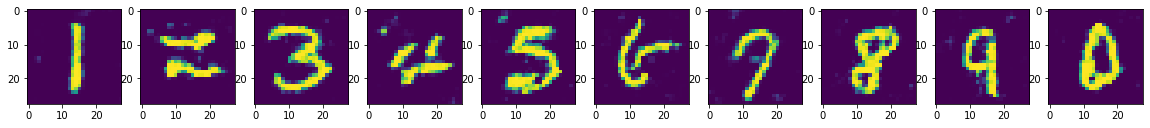

In [ ]:
labels = [1,2,3,4,5,6,7,8,9,0]
labels = torch.Tensor(labels)
latent = torch.randn(len(labels), latent_size, 1,1).to(device)
target = nn.functional.one_hot(labels.long().unsqueeze(1).unsqueeze(1), 10).permute(0,3,1,2).float()
target = (target*0.9).to(device)
fake_images = generator(latent, target).to(device)
fig, ax = plt.subplots(1, len(labels), figsize=(20, 5))
for col in range(len(labels)):
    ax[col].imshow(fake_images[col].squeeze(0).detach().cpu().numpy())

In [ ]:
labels.shape

torch.Size([10])

In [ ]:
batch_size=10
with torch.no_grad():
    c = torch.eye(10, 10).to(device)
#   vec=[1,0,0,0,0,0,0,0,0,0,0]
    sample = torch.randn(10,latent_size).to(device)
    sample = model.decode(sample, c).to(device)
    save_image(sample.view(10, 1, 28, 28),
                'sample_' + '.png')